In [5]:
# CELL 1 - IMPORTS E CONFIGURAÇÕES INICIAIS
# ============================================================================
"""
Esta célula carrega todas as bibliotecas necessárias e configura a apresentação
visual dos gráficos que serão gerados ao longo da análise.
"""

import pandas as pd                    # Manipulação de dados em tabelas (DataFrames)
import numpy as np                     # Operações matemáticas e arrays
import matplotlib.pyplot as plt        # Criação de gráficos
import seaborn as sns                  # Gráficos estatísticos mais bonitos
from scipy.stats import pearsonr, shapiro, ttest_ind  # Testes estatísticos
import re                              # Expressões regulares para limpeza de texto
import warnings                        # Controle de avisos
import requests                        # Fazer requisições HTTP (web scraping)
from bs4 import BeautifulSoup         # Analisar HTML (web scraping)
import time                            # Controlar delays entre requisições
import unicodedata                     # Remover acentos
import random                          # Gerar números aleatórios
from requests.adapters import HTTPAdapter      # Sessão mais robusta
from urllib3.util.retry import Retry           # Retry automático
from sklearn.preprocessing import StandardScaler  # Padronizar variáveis
from sklearn.cluster import KMeans     # Agrupamento de municípios
from sklearn.linear_model import LinearRegression  # Modelo preditivo
from sklearn.metrics import r2_score   # Avaliar ajuste do modelo

# Suprimir avisos desnecessários
warnings.filterwarnings('ignore')

# CONFIGURAR VISUALIZAÇÃO DOS GRÁFICOS
plt.style.use('default')               # Estilo padrão dos gráficos
sns.set_palette("Set2")                # Paleta de cores agradável
plt.rcParams['figure.figsize'] = (15, 10)  # Tamanho padrão dos gráficos
plt.rcParams['font.size'] = 10         # Tamanho da fonte

print("🔍 ANÁLISE COMPLETA MELHORADA: CRIMINALIDADE E FATORES SOCIOECONÔMICOS")
print("="*80)

🔍 ANÁLISE COMPLETA MELHORADA: CRIMINALIDADE E FATORES SOCIOECONÔMICOS


In [6]:
# ============================================================================
# CELL 2 - FUNÇÕES AUXILIARES DE LIMPEZA DE DADOS
# ============================================================================
"""
Estas funções limpam e padronizam os dados brutos obtidos do web scraping
e dos arquivos CSV. Dados "sujos" causam erros na análise.
"""

import unicodedata

def remover_acentos(texto):
    """
    Remove acentos de texto para facilitar buscas e matching.
    Exemplo: "São Paulo" vira "Sao Paulo"
    """
    return unicodedata.normalize('NFD', texto).encode('ascii', 'ignore').decode('ascii')

def limpar_nome_municipio(nome):
    """
    Padroniza nomes de municípios para web scraping.
    Exemplo: "belo horizonte" vira "Belo Horizonte"
    Mantém preposições (de, da, do) em minúsculas.
    """
    nome = nome.strip()  # Remove espaços extras
    nome = nome.title()  # Primeira letra maiúscula
    preposicoes = ['De', 'Da', 'Do', 'Das', 'Dos', 'E']
    palavras = nome.split()
    
    for i, palavra in enumerate(palavras):
        if i > 0 and palavra in preposicoes:
            palavras[i] = palavra.lower()  # Preposição fica minúscula
    
    return ' '.join(palavras)

def limpar_numero_melhorado(texto):
    """
    Extrai números de texto e converte para float.
    Lida com formatos: "1.234,56" (brasileiro) ou "1,234.56" (americano)
    Exemplo: "População: 123.456 hab" vira 123456.0
    """
    if pd.isna(texto):
        return np.nan
    
    texto = str(texto)
    # Buscar padrão numérico no texto
    match = re.search(r'[\d\.,]+', texto)
    
    if match:
        numero_str = match.group()
        
        # Se tem tanto vírgula quanto ponto, assume separador brasileiro
        if ',' in numero_str and '.' in numero_str:
            numero_str = numero_str.replace('.', '').replace(',', '.')
        elif ',' in numero_str:
            # Só vírgula: se tem 1-2 dígitos após vírgula, é decimal
            if numero_str.count(',') == 1 and len(numero_str.split(',')[1]) <= 2:
                numero_str = numero_str.replace('.', '').replace(',', '.')
            else:
                numero_str = numero_str.replace(',', '')
        else:
            # Só ponto: se tem 1-2 dígitos após ponto, é decimal
            if numero_str.count('.') > 0:
                parts = numero_str.split('.')
                if len(parts[-1]) <= 2 and len(parts) > 1:
                    numero_str = ''.join(parts[:-1]) + '.' + parts[-1]
                else:
                    numero_str = numero_str.replace('.', '')
        
        try:
            return float(numero_str)
        except:
            return np.nan
    
    return np.nan

def limpar_valor_melhorado(texto):
    """
    Limpa valores socioeconômicos (percentuais, IDHM, etc).
    Remove símbolos especiais, colchetes e porcentagem.
    Exemplo: "98,5%" vira 98.5
    """
    if pd.isna(texto):
        return np.nan
    
    texto = str(texto)
    # Remove tudo após % ou [
    texto = re.sub(r'%.*', '', texto)
    texto = re.sub(r'\[.*?\]', '', texto)
    
    match = re.search(r'[\d\.,]+', texto.strip())
    
    if match:
        numero_str = match.group()
        # Mesmo processo de limpeza do limpar_numero_melhorado
        if ',' in numero_str and '.' in numero_str:
            numero_str = numero_str.replace('.', '').replace(',', '.')
        elif ',' in numero_str:
            if numero_str.count(',') == 1 and len(numero_str.split(',')[1]) <= 2:
                numero_str = numero_str.replace('.', '').replace(',', '.')
            else:
                numero_str = numero_str.replace(',', '')
        else:
            if numero_str.count('.') > 0:
                parts = numero_str.split('.')
                if len(parts[-1]) <= 2 and len(parts) > 1:
                    numero_str = ''.join(parts[:-1]) + '.' + parts[-1]
                else:
                    numero_str = numero_str.replace('.', '')
        
        try:
            return float(numero_str)
        except:
            return np.nan
    
    return np.nan

def limpar_valor_orcamento(texto):
    """
    Limpa valores de orçamento (reais em R$).
    Remove "R$", espaços e letras desnecessárias.
    Exemplo: "R$ 1.234.567,89" vira 1234567.89
    """
    if pd.isna(texto) or texto == "Não encontrado":
        return np.nan
    
    texto = str(texto)
    # Remove símbolos de moeda e espaços
    texto = re.sub(r'[R$\s]', '', texto)
    # Remove outras letras
    texto = re.sub(r'[a-zA-Z]+', '', texto)
    
    match = re.search(r'[\d\.,]+', texto)
    
    if match:
        numero_str = match.group()
        if ',' in numero_str and '.' in numero_str:
            numero_str = numero_str.replace('.', '').replace(',', '.')
        elif ',' in numero_str:
            if numero_str.count(',') == 1 and len(numero_str.split(',')[1]) <= 2:
                numero_str = numero_str.replace(',', '.')
            else:
                numero_str = numero_str.replace(',', '')
        
        try:
            return float(numero_str)
        except:
            return np.nan
    
    return np.nan

In [7]:
# ============================================================================
# CELL 3 - WEB SCRAPING IBGE
# ============================================================================
"""
Faz download automático de dados dos municípios do site do IBGE.
Extrai informações como população, IDHM, escolarização, etc.
"""

def web_scraping_ibge(todos_municipios):
    """
    Web scraping dos dados do IBGE para lista de municípios.
    
    Parâmetros:
    - todos_municipios: lista com nomes dos municípios
    
    Retorna:
    - DataFrame com dados do IBGE para cada município
    """
    print("\n🌐 EXECUTANDO WEB SCRAPING - DADOS IBGE")
    print("="*50)
    
    def monta_url_ibge(municipio):
        """
        Constrói URL do IBGE baseado no nome do município.
        Exemplo: "Belo Horizonte" -> "ibge.gov.br/.../belo-horizonte.html"
        """
        municipio_formatado = remover_acentos(municipio.lower()).replace(" ", "-")
        return f"https://www.ibge.gov.br/cidades-e-estados/mg/{municipio_formatado}.html"

    # Header para parecer um navegador real
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    dados = {}  # Dicionário para armazenar dados de cada município
    print(f"Buscando dados para {len(todos_municipios)} municípios de MG...")

    for municipio in todos_municipios:
        url = monta_url_ibge(municipio)
        print(f"\n🔎 Acessando {municipio}...")
        
        try:
            time.sleep(1)  # Aguardar 1 segundo entre requisições (respeitar servidor)
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()  # Verificar se não houve erro
            
            # Analisar HTML da página
            soup = BeautifulSoup(response.text, "html.parser")
            # Buscar elementos que contêm os indicadores
            itens = soup.select("ul.resultados-padrao li")

            indicadores = {}  # Indicadores deste município
            
            for item in itens:
                nome = item.select_one(".ind-label p")  # Nome do indicador
                valor = item.select_one(".ind-value")   # Valor do indicador
                
                if nome and valor:
                    nome_texto = nome.get_text(strip=True)
                    valor_texto = valor.get_text(" ", strip=True)
                    indicadores[nome_texto] = valor_texto

            if indicadores:
                dados[municipio] = indicadores
                print(f"✅ Dados coletados para {municipio}")
            else:
                print(f"❌ Nenhum dado encontrado para {municipio}")
                
        except Exception as e:
            print(f"⚠️ Erro ao buscar {municipio}: {e}")

    # Converter para DataFrame e salvar em CSV
    if dados:
        df = pd.DataFrame.from_dict(dados, orient="index").reset_index()
        df = df.rename(columns={"index": "Municipio"})
        df.to_csv("dados_municipios_ibge.csv", index=False, encoding="utf-8")
        print(f"\n📄 Arquivo salvo: dados_municipios_ibge.csv")
        return df
    else:
        print("\n❌ Nenhum dado foi coletado!")
        return pd.DataFrame()


In [8]:
# ============================================================================
# CELL 4 - WEB SCRAPING CÓDIGOS IBGE
# ============================================================================
"""
Obtém os códigos de identificação dos municípios (COD_IBGE).
Necessário para consultar dados de orçamento e encarceramento.
"""

def web_scraping_codigos_ibge():
    """
    Web scraping para obter códigos IBGE de municípios.
    Estes códigos são necessários para outras consultas.
    """
    print("\n🌐 EXECUTANDO WEB SCRAPING - CÓDIGOS IBGE")
    print("="*50)
    
    url_ibge = "https://www.ibge.gov.br/explica/codigos-dos-municipios.php"
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    try:
        time.sleep(1)
        response = requests.get(url_ibge, headers=headers, timeout=15)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, "html.parser")
        # Cada linha da tabela representa um município
        linhas_municipios = soup.find_all("tr", class_="municipio data-line")
        
        codigos_ibge = {}  # Dict: nome_sem_acento -> código
        
        for linha in linhas_municipios:
            link = linha.find("a")  # Link com nome do município
            
            if link:
                nome_municipio = link.get_text(strip=True)
                # Procurar célula com o código
                td_codigo = linha.find("td", class_="numero")
                
                if td_codigo:
                    codigo = td_codigo.get_text(strip=True)
                    # Usar nome sem acento como chave para matching posterior
                    nome_sem_acento = remover_acentos(nome_municipio.lower())
                    codigos_ibge[nome_sem_acento] = {
                        'nome_original': nome_municipio,
                        'codigo': codigo
                    }
        
        print(f"Total de códigos coletados: {len(codigos_ibge)}")
        return codigos_ibge
        
    except Exception as e:
        print(f"Erro: {e}")
        return {}

In [9]:
# ============================================================================
# CELL 5 - WEB SCRAPING ORÇAMENTOS
# ============================================================================
"""
Obtém dados orçamentários do Portal da Transparência (gov.br).
Informações sobre transferências de recursos e gastos públicos.
"""

def create_advanced_session():
    """
    Cria uma sessão HTTP mais robusta que respeita limites do servidor.
    Implementa retry automático e headers mais realistas.
    """
    session = requests.Session()
    
    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36'
    })
    
    # Configurar retry automático
    try:
        retry_strategy = Retry(
            total=2,  # Número máximo de tentativas
            status_forcelist=[429, 500, 502, 503, 504],  # Erros a tentar novamente
            allowed_methods=["HEAD", "GET", "OPTIONS"],
            backoff_factor=3  # Aguardar 3 segundos entre tentativas
        )
    except TypeError:
        # Versão antiga do urllib3
        retry_strategy = Retry(
            total=2,
            status_forcelist=[429, 500, 502, 503, 504],
            method_whitelist=["HEAD", "GET", "OPTIONS"],
            backoff_factor=3
        )
    
    # Aplicar estratégia de retry
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    
    return session

def web_scraping_orcamentos(df_municipios_com_codigo):
    """
    Web scraping de dados orçamentários do Portal da Transparência.
    Obtém recursos transferidos e gastos por município.
    
    Parâmetros:
    - df_municipios_com_codigo: DataFrame com coluna "Codigo_IBGE"
    
    Retorna:
    - DataFrame com dados orçamentários por município
    """
    print("\n🌐 EXECUTANDO WEB SCRAPING - DADOS ORÇAMENTÁRIOS")
    print("="*50)
    
    resultados = []
    erros = []
    session = create_advanced_session()
    
    for index, row in df_municipios_com_codigo.iterrows():
        codigo = str(row["Codigo_IBGE"])
        municipio = row["Municipio"]
        
        # Pular se código não foi encontrado
        if codigo == "Não encontrado":
            continue
        
        # URL do Portal da Transparência
        url = f"https://portaldatransparencia.gov.br/localidades/{codigo}"
        print(f"🏙️  [{index+1:2d}/{len(df_municipios_com_codigo)}] {municipio}")
        
        try:
            # Aguardar tempo aleatório entre 3-7 segundos (respeitar servidor)
            delay = random.uniform(3, 7)
            time.sleep(delay)
            
            response = session.get(url, timeout=25)
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                
                def get_valor(id_tag):
                    """Extrai valor de um elemento HTML por ID"""
                    tag = soup.find("span", {"id": id_tag})
                    return tag.get_text(strip=True) if tag else "Não encontrado"
                
                # Coletar dados orçamentários
                dados = {
                    "codigo_ibge": codigo,
                    "municipio": municipio,
                    "recursos_estado": get_valor("recursosTransferidosAoGovernoEstadual"),
                    "recursos_municipio": get_valor("recursosTransferidosAoMunicipio"),
                    "gastos_diretos": get_valor("gastosDiretosGovernoFederalNaLocalidade"),
                    "beneficios": get_valor("beneficiosNaLocalidade"),
                }
                
                resultados.append(dados)
                print(f"   ✅ Dados coletados!")
            else:
                print(f"   ❌ Status {response.status_code}")
                
        except Exception as e:
            print(f"   ❌ Erro: {str(e)[:50]}...")
            erros.append({'municipio': municipio, 'codigo': codigo, 'erro': str(e)})
    
    session.close()
    
    # Salvar resultados
    if resultados:
        df_resultados = pd.DataFrame(resultados)
        df_resultados.to_csv("orcamentos_municipios.csv", index=False, encoding="utf-8")
        print(f"✅ {len(resultados)} municípios salvos em 'orcamentos_municipios.csv'")
        return df_resultados
    else:
        print("❌ Nenhum dado foi coletado!")
        return pd.DataFrame()


In [10]:
# ============================================================================
# CELL 5B - CARREGAMENTO E PROCESSAMENTO DE DADOS CARCERÁRIOS
# ============================================================================
"""
Carrega dados de encarceramento do arquivo Excel e integra com análise de crimes.
Cria taxa de encarceramento por município e relaciona com criminalidade.
"""

def carregar_e_processar_dados_carcerarios():
    """
    Carrega arquivo Excel com dados carcerários APENAS DE 2024.
    Columns esperadas: COD_IBGE, MUNICIPIO, CONTAGEM_IPL, ESCOLARIDADE_NA_ADMISSAO, ANO, MES_NUMERICO
    
    Retorna:
    - DataFrame com população carcerária agregada por município (2024)
    """
    print("\n📊 CARREGANDO DADOS CARCERÁRIOS...")
    print("="*50)
    
    try:
        # Carregar arquivo Excel
        arquivo_carcerario = 'Dados Abertos_Pop_Pris_Sexo_Escolaridade_Jan_2017_Jun_2024.xlsx'
        df_carcerario = pd.read_excel(arquivo_carcerario, sheet_name=0)
        
        print(f"✅ Arquivo carregado: {len(df_carcerario)} registros (todos os anos)")
        print(f"Colunas disponíveis: {list(df_carcerario.columns)}")
        
    except FileNotFoundError:
        print(f"❌ Arquivo '{arquivo_carcerario}' não encontrado!")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Erro ao carregar arquivo: {e}")
        return pd.DataFrame()
    
    # ============================================================
    # 🆕 FILTRAR APENAS 2024
    # ============================================================
    print("\n🔍 FILTRANDO DADOS DE 2024...")
    
    if 'ANO' in df_carcerario.columns:
        # Converter ANO para numérico
        df_carcerario['ANO'] = pd.to_numeric(df_carcerario['ANO'], errors='coerce')
        
        # Mostrar anos disponíveis no arquivo
        anos_disponiveis = df_carcerario['ANO'].dropna().unique()
        print(f"   Anos disponíveis: {sorted(anos_disponiveis)}")
        
        # Filtrar apenas 2024
        df_carcerario = df_carcerario[df_carcerario['ANO'] == 2024].copy()
        
        print(f"   ✅ Filtrado para 2024: {len(df_carcerario)} registros")
    else:
        print("   ⚠️ Coluna 'ANO' não encontrada!")
    
    # LIMPEZA E PADRONIZAÇÃO
    print("\n🧹 LIMPANDO DADOS CARCERÁRIOS...")
    
    # Garantir que COD_IBGE é string/int conforme necessário
    if 'COD_IBGE' in df_carcerario.columns:
        df_carcerario['COD_IBGE'] = pd.to_numeric(df_carcerario['COD_IBGE'], errors='coerce')
    
    # Garantir que CONTAGEM_IPL é numérica (população carcerária)
    if 'CONTAGEM_IPL' in df_carcerario.columns:
        df_carcerario['CONTAGEM_IPL'] = pd.to_numeric(df_carcerario['CONTAGEM_IPL'], errors='coerce')
    
    # Padronizar nomes de municípios
    if 'MUNICIPIO' in df_carcerario.columns:
        df_carcerario['MUNICIPIO_Clean'] = (
            df_carcerario['MUNICIPIO']
            .str.strip()
            .str.upper()
        )
    
    # AGREGAÇÃO POR MUNICÍPIO
    print("\n📈 AGREGANDO DADOS POR MUNICÍPIO (2024)...")
    
    # Agrupar por município: somar população carcerária
    df_carcerario_agrupado = df_carcerario.groupby('MUNICIPIO_Clean').agg({
        'CONTAGEM_IPL': 'sum',  # Total de presos em 2024
        'MUNICIPIO': 'first',    # Nome original
        'COD_IBGE': 'first'      # Código IBGE
    }).reset_index()
    
    df_carcerario_agrupado.columns = ['MUNICIPIO_Clean', 'Total_Presos', 'Municipio_Carcerario', 'COD_IBGE']
    
    # Análise de escolaridade dos presos (opcional)
    print("\n📚 ANALISANDO ESCOLARIDADE DOS PRESOS (2024)...")
    
    if 'ESCOLARIDADE_NA_ADMISSAO' in df_carcerario.columns:
        # Tabela de escolaridade por município
        escolaridade_dist = df_carcerario.groupby(['MUNICIPIO_Clean', 'ESCOLARIDADE_NA_ADMISSAO']).agg({
            'CONTAGEM_IPL': 'sum'
        }).reset_index()
        
        # Escolaridade mais comum por município
        escolaridade_modal = escolaridade_dist.loc[
            escolaridade_dist.groupby('MUNICIPIO_Clean')['CONTAGEM_IPL'].idxmax()
        ]
        
        df_carcerario_agrupado = pd.merge(
            df_carcerario_agrupado,
            escolaridade_modal[['MUNICIPIO_Clean', 'ESCOLARIDADE_NA_ADMISSAO']].rename(
                columns={'ESCOLARIDADE_NA_ADMISSAO': 'Escolaridade_Modal_Presos'}
            ),
            on='MUNICIPIO_Clean',
            how='left'
        )
        
        print(f"✅ Escolaridade modal dos presos (2024) calculada")
    
    # Análise por sexo (se disponível)
    if 'COD_SEXO' in df_carcerario.columns or 'SEXO_NA_ADMISSAO' in df_carcerario.columns:
        sexo_col = 'SEXO_NA_ADMISSAO' if 'SEXO_NA_ADMISSAO' in df_carcerario.columns else 'COD_SEXO'
        
        # Proporção por sexo
        sexo_dist = df_carcerario.groupby(['MUNICIPIO_Clean', sexo_col]).agg({
            'CONTAGEM_IPL': 'sum'
        }).reset_index().pivot(
            index='MUNICIPIO_Clean',
            columns=sexo_col,
            values='CONTAGEM_IPL'
        ).fillna(0)
        
        # Calcular proporção masculina
        if sexo_dist.shape[1] >= 2:
            total_por_municipio = sexo_dist.sum(axis=1)
            sexo_dist_prop = sexo_dist.div(total_por_municipio, axis=0)
            
            df_carcerario_agrupado['Proporcao_Masculina'] = (
                sexo_dist_prop.iloc[:, 0] if sexo_dist_prop.iloc[:, 0].mean() > 0.5 
                else sexo_dist_prop.iloc[:, 1]
            )
            
            print(f"✅ Proporção por sexo (2024) calculada")
    
    print(f"\n✅ Dados carcerários (2024) processados: {len(df_carcerario_agrupado)} municípios")
    
    # Salvar em CSV
    df_carcerario_agrupado.to_csv('dados_carcerarios_agrupados_2024.csv', index=False, encoding='utf-8')
    print(f"💾 Arquivo salvo: 'dados_carcerarios_agrupados_2024.csv'")
    
    return df_carcerario_agrupado


def calcular_taxa_encarceramento(df_completo, df_carcerario):
    """
    Calcula Taxa de Encarceramento (presos por 100 mil habitantes).
    Merge com dados de crimes para análise integrada.
    
    Parâmetros:
    - df_completo: DataFrame com dados gerais (já com população)
    - df_carcerario: DataFrame com dados carcerários agregados
    
    Retorna:
    - DataFrame mergeado com Taxa_Encarceramento adicionada
    """
    print("\n📊 CALCULANDO TAXA DE ENCARCERAMENTO...")
    print("="*50)
    
    # Preparar coluna Clean para merge
    if 'Municipio_Carcerario' in df_carcerario.columns:
        df_carcerario['Municipio_Clean'] = (
            df_carcerario['Municipio_Carcerario']
            .str.strip()
            .str.upper()
        )
    
    # Merge com dados principais
    df_resultado = pd.merge(
        df_completo,
        df_carcerario[['Municipio_Clean', 'Total_Presos', 'Escolaridade_Modal_Presos']],
        on='Municipio_Clean',
        how='left'
    )
    
    # Calcular Taxa de Encarceramento
    if 'Total_Presos' in df_resultado.columns and 'Populacao_Limpa' in df_resultado.columns:
        df_resultado['Taxa_Encarceramento'] = (
            (df_resultado['Total_Presos'] / df_resultado['Populacao_Limpa']) * 100000
        )
        
        print(f"✅ Taxa de Encarceramento calculada")
        print(f"\nEstatísticas da Taxa de Encarceramento:")
        print(f"   Mínima: {df_resultado['Taxa_Encarceramento'].min():.1f} presos/100k")
        print(f"   Máxima: {df_resultado['Taxa_Encarceramento'].max():.1f} presos/100k")
        print(f"   Média: {df_resultado['Taxa_Encarceramento'].mean():.1f} presos/100k")
        print(f"   Mediana: {df_resultado['Taxa_Encarceramento'].median():.1f} presos/100k")
    
    return df_resultado


def correlacao_crimes_encarceramento(df_final):
    """
    Analisa correlação entre Taxa de Crimes e Taxa de Encarceramento.
    Gera gráficos e estatísticas.
    
    Parâmetros:
    - df_final: DataFrame com Taxa_Crimes e Taxa_Encarceramento
    """
    print("\n🔗 ANÁLISE: CRIMES vs ENCARCERAMENTO")
    print("="*50)
    
    if 'Taxa_Crimes' not in df_final.columns or 'Taxa_Encarceramento' not in df_final.columns:
        print("❌ Colunas Taxa_Crimes ou Taxa_Encarceramento não encontradas!")
        return
    
    # Remover NaN
    dados_corr = df_final[['Taxa_Crimes', 'Taxa_Encarceramento', 'Municipio']].dropna()
    
    if len(dados_corr) < 5:
        print("❌ Dados insuficientes para correlação")
        return
    
    # Correlação de Pearson
    r, p_value = pearsonr(dados_corr['Taxa_Crimes'], dados_corr['Taxa_Encarceramento'])
    
    print(f"\n📈 CORRELAÇÃO (Pearson):")
    print(f"   r = {r:.3f}")
    print(f"   p-value = {p_value:.4f}")
    print(f"   Significância: {'✅ Significativa (p < 0.05)' if p_value < 0.05 else '❌ Não significativa'}")
    
    # Interpretação
    if abs(r) >= 0.7:
        print(f"   Interpretação: Correlação FORTE")
    elif abs(r) >= 0.4:
        print(f"   Interpretação: Correlação MODERADA")
    elif abs(r) >= 0.2:
        print(f"   Interpretação: Correlação FRACA")
    else:
        print(f"   Interpretação: Correlação MUITO FRACA")
    
    # Gráfico scatter
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot
    ax1 = axes[0]
    cores = {'Mais_Crimes': '#e74c3c', 'Menos_Crimes': '#2ecc71'}
    
    if 'Categoria' in dados_corr.columns:
        for categoria, cor in cores.items():
            sub = dados_corr[dados_corr['Categoria'] == categoria]
            if len(sub) > 0:
                ax1.scatter(sub['Taxa_Crimes'], sub['Taxa_Encarceramento'], 
                           c=cor, alpha=0.7, s=80, label=categoria.replace('_', ' '), edgecolors='k')
    else:
        ax1.scatter(dados_corr['Taxa_Crimes'], dados_corr['Taxa_Encarceramento'], 
                   c='#3498db', alpha=0.7, s=80, edgecolors='k')
    
    # Linha de regressão
    try:
        sns.regplot(data=dados_corr, x='Taxa_Crimes', y='Taxa_Encarceramento', 
                   scatter=False, ax=ax1, color='navy', line_kws={'linewidth': 2})
    except Exception:
        pass
    
    ax1.set_xlabel('Taxa de Crimes (por 100k hab)', fontsize=11)
    ax1.set_ylabel('Taxa de Encarceramento (por 100k hab)', fontsize=11)
    ax1.set_title(f'Crimes vs Encarceramento\n(r = {r:.3f}, p = {p_value:.4f})', 
                 fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    # Distribuição de ambas
    ax2 = axes[1]
    ax2.hist(dados_corr['Taxa_Crimes'], bins=15, alpha=0.6, label='Taxa de Crimes', color='#e74c3c')
    ax2_twin = ax2.twinx()
    ax2_twin.hist(dados_corr['Taxa_Encarceramento'], bins=15, alpha=0.6, 
                 label='Taxa de Encarceramento', color='#3498db')
    
    ax2.set_xlabel('Taxa (por 100k hab)', fontsize=11)
    ax2.set_ylabel('Frequência - Crimes', color='#e74c3c', fontsize=10)
    ax2_twin.set_ylabel('Frequência - Encarceramento', color='#3498db', fontsize=10)
    ax2.set_title('Distribuição das Taxas', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # TOP 5 municípios com maior encarceramento
    print(f"\n🔝 TOP 5 MUNICÍPIOS COM MAIOR TAXA DE ENCARCERAMENTO:")
    top5 = dados_corr.nlargest(5, 'Taxa_Encarceramento')[['Municipio', 'Taxa_Crimes', 'Taxa_Encarceramento']]
    for idx, (_, row) in enumerate(top5.iterrows(), 1):
        print(f"   {idx}. {row['Municipio']}: {row['Taxa_Encarceramento']:.1f} presos/100k "
              f"(crimes: {row['Taxa_Crimes']:.1f}/100k)")


In [11]:
# ============================================================================
# CELL 6 - ANÁLISES ESTATÍSTICAS AVANÇADAS E MODELO PREDITIVO
# ============================================================================
"""
Esta célula executa testes estatísticos para validar achados.
Inclui testes de normalidade, comparação de grupos e agrupamento (clustering).
"""

def analises_estatisticas_avancadas(df_final):
    """
    Executa testes estatísticos robustos:
    - Teste de Shapiro-Wilk (normalidade)
    - Teste t (comparação de grupos)
    - K-Means (agrupamento de municípios)
    """
    print("\n🔬 ANÁLISES ESTATÍSTICAS AVANÇADAS")
    print("="*50)

    # 1) TESTE DE NORMALIDADE (Shapiro-Wilk)
    print("\n📊 TESTE DE NORMALIDADE (Shapiro-Wilk):")
    # Lista de variáveis para testar
    variaveis_teste = ['Taxa_Crimes', 'PIB_Limpo', 'Total_Recursos_PerCapita', 'Escolarizacao_Limpa']

    for var in variaveis_teste:
        if var in df_final.columns:
            dados_limpos = df_final[var].dropna()
            
            if len(dados_limpos) > 3:
                try:
                    # Teste Shapiro-Wilk (H0: dados são normais)
                    # p-value > 0.05 = dados são normais
                    stat, p_value = shapiro(dados_limpos.dropna())
                    normal = "✅ Normal" if p_value > 0.05 else "❌ Não Normal"
                    print(f"   {var}: p-value = {p_value:.4f} ({normal})")
                except Exception as e:
                    print(f"   {var}: erro no teste Shapiro ({e})")

    # 2) TESTE T (Comparar grupos)
    print(f"\n🧪 TESTE T - DIFERENÇAS ENTRE MAIS E MENOS CRIMES:")
    # Separar municípios por categoria
    mais_crimes = df_final[df_final['Categoria'] == 'Mais_Crimes'] if 'Categoria' in df_final.columns else pd.DataFrame()
    menos_crimes = df_final[df_final['Categoria'] == 'Menos_Crimes'] if 'Categoria' in df_final.columns else pd.DataFrame()

    # Testar diferenças em cada variável
    for var in ['PIB_Limpo', 'Total_Recursos_PerCapita', 'Escolarizacao_Limpa']:
        if var in df_final.columns and not mais_crimes.empty and not menos_crimes.empty:
            dados_mais = mais_crimes[var].dropna()
            dados_menos = menos_crimes[var].dropna()

            if len(dados_mais) > 1 and len(dados_menos) > 1:
                try:
                    # Teste t (H0: médias são iguais)
                    t_stat, p_value = ttest_ind(dados_mais, dados_menos, equal_var=False)
                    significativo = "📊 Significativo" if p_value < 0.05 else "🔄 Não significativo"

                    print(f"\n   {var}:")
                    print(f"      Mais crimes - Média: {dados_mais.mean():.2f} (n={len(dados_mais)})")
                    print(f"      Menos crimes - Média: {dados_menos.mean():.2f} (n={len(dados_menos)})")
                    print(f"      p-value: {p_value:.4f} ({significativo})")
                except Exception as e:
                    print(f"   {var}: erro no teste t ({e})")

    # 3) AGRUPAMENTO COM K-MEANS
    print(f"\n🎯 ANÁLISE DE CLUSTERS (K-Means):")
    
    # Variáveis para agrupamento
    vars_cluster = ['Taxa_Crimes', 'PIB_Limpo', 'Total_Recursos_PerCapita', 'Escolarizacao_Limpa']
    vars_disponiveis = [var for var in vars_cluster if var in df_final.columns]

    if len(vars_disponiveis) >= 2:
        # Preparar dados para clustering
        dados_cluster = df_final[vars_disponiveis].dropna()

        if len(dados_cluster) > 5:
            # Padronizar variáveis (média 0, desvio padrão 1)
            scaler = StandardScaler()
            dados_padronizados = scaler.fit_transform(dados_cluster)

            # K-Means com 3 clusters
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(dados_padronizados)

            # Adicionar resultado ao DataFrame original
            df_final.loc[dados_cluster.index, 'Cluster'] = clusters

            print(f"   ✅ {len(dados_cluster)} municípios agrupados em 3 clusters")

            # Mostrar distribuição dos clusters
            cluster_counts = pd.Series(clusters).value_counts().sort_index()
            for cluster, count in cluster_counts.items():
                print(f"      Cluster {cluster}: {count} municípios")

    return df_final


def criar_modelo_preditivo(df_final):
    """
    Cria um modelo de regressão linear simples.
    Objetivo: prever Taxa_Crimes usando PIB, Escolarização e Recursos.
    
    Retorna:
    - modelo: objeto do sklearn
    - r2: score R² (qualidade do ajuste)
    """
    print(f"\n🤖 MODELO PREDITIVO SIMPLES")
    print("="*30)

    # Escolher variáveis preditoras disponíveis
    vars_preditoras = []
    for var in ['PIB_Limpo', 'Escolarizacao_Limpa', 'Total_Recursos_PerCapita']:
        if var in df_final.columns:
            vars_preditoras.append(var)

    if len(vars_preditoras) >= 2:
        # Preparar dados (remover NaN)
        dados_modelo = df_final[vars_preditoras + ['Taxa_Crimes']].dropna()

        if len(dados_modelo) > 5:
            # Separar preditores (X) e alvo (y)
            X = dados_modelo[vars_preditoras]
            y = dados_modelo['Taxa_Crimes']

            # Ajustar modelo linear
            modelo = LinearRegression()
            modelo.fit(X, y)
            
            # Fazer predições
            predicoes = modelo.predict(X)

            # Calcular R² (0 = péssimo, 1 = perfeito)
            r2 = r2_score(y, predicoes)
            print(f"R² Score: {r2:.3f} (explica {r2*100:.1f}% da variação)")

            # Identificar outliers (resíduos grandes)
            residuos = y - predicoes
            threshold = residuos.std() * 2  # 2 desvios padrão
            outliers = dados_modelo[abs(residuos) > threshold]

            if len(outliers) > 0:
                print(f"\n🔍 MUNICÍPIOS ATÍPICOS:")
                for idx, row in outliers.head(5).iterrows():
                    municipio_nome = df_final.loc[idx, 'Municipio'] if 'Municipio' in df_final.columns else f"ID {idx}"
                    taxa = row['Taxa_Crimes']
                    print(f"   {municipio_nome}: {taxa:.1f} crimes/100k")

            return modelo, r2

    print("❌ Dados insuficientes para modelo preditivo")
    return None, 0


In [31]:
# ============================================================================
# CELL 7A - VISUALIZAÇÕES PROFISSIONAIS (PARTE 1: CORRELAÇÕES)
# ============================================================================
"""
Gera gráficos de correlações e comparações PIB vs Crimes
"""

def criar_visualizacoes_correlacoes(df_final):
    """Gera figura 1: Heatmap + Scatter PIB"""
    print(f"\n📊 GERANDO VISUALIZAÇÕES - CORRELAÇÕES...")

    df = df_final.copy()

    if 'Municipio' not in df.columns:
        for cand in ['Municipio', 'Municipio_Crimes', 'Município']:
            if cand in df.columns:
                df['Municipio'] = df[cand]
                break

    for col in ['PIB_Limpo', 'Total_Recursos_PerCapita', 'Taxa_Crimes']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if 'PIB_Limpo' in df.columns:
        df['PIB_log'] = np.log1p(df['PIB_Limpo'].clip(lower=0))

    # Figura 1: Heatmap + Scatter PIB
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

    # Gráfico 1: Heatmap de Correlações
    ax1 = fig.add_subplot(gs[0, 0])
    vars_corr = [v for v in ['Taxa_Crimes', 'PIB_Limpo', 'Total_Recursos_PerCapita', 
                              'Escolarizacao_Limpa', 'IDHM_Limpo', 'Beneficios_PerCapita',
                              'Taxa_Encarceramento'] 
                 if v in df.columns]
    
    if len(vars_corr) >= 2:
        matriz_corr = df[vars_corr].corr()
        sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
                    square=True, ax=ax1, cbar_kws={"shrink": 0.8})
        ax1.set_title('Matriz de Correlações', fontsize=13, fontweight='bold')

    # Gráfico 2: Scatter - PIB vs Taxa de Crimes
    ax2 = fig.add_subplot(gs[0, 1])
    
    if 'PIB_log' in df.columns and 'Taxa_Crimes' in df.columns:
        dados_scatter = df[['PIB_log', 'PIB_Limpo', 'Taxa_Crimes', 'Categoria', 'Municipio']].dropna()
        
        cores = {'Mais_Crimes': '#e74c3c', 'Menos_Crimes': '#2ecc71'}
        
        for categoria, cor in cores.items():
            sub = dados_scatter[dados_scatter['Categoria'] == categoria] if 'Categoria' in dados_scatter.columns else dados_scatter
            if len(sub) > 0:
                ax2.scatter(sub['PIB_log'], sub['Taxa_Crimes'], c=cor, alpha=0.75, 
                           s=60, label=categoria.replace('_', ' '), edgecolors='k', linewidth=0.4)

        try:
            sns.regplot(data=dados_scatter, x='PIB_log', y='Taxa_Crimes', scatter=False, 
                       ax=ax2, color='navy', line_kws={'linewidth':2, 'alpha':0.6})
        except:
            pass

        try:
            r, p = pearsonr(dados_scatter['PIB_log'], dados_scatter['Taxa_Crimes'])
            ax2.annotate(f'r = {r:.2f}\np = {p:.3f}', xy=(0.02, 0.95), 
                        xycoords='axes fraction', fontsize=10, 
                        bbox=dict(boxstyle='round', fc='white', alpha=0.7))
        except:
            pass

        ax2.set_xlabel('PIB per capita (R$)')
        ax2.set_ylabel('Taxa de Crimes (por 100k hab)')
        ax2.set_title('PIB per capita vs Criminalidade', fontsize=13, fontweight='bold')
        ax2.legend(frameon=True)
        ax2.grid(alpha=0.25)

    plt.suptitle('ANÁLISE 1: CORRELAÇÕES E FATORES SOCIOECONÔMICOS', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig('figura_01_correlacoes_pib.png', dpi=300, bbox_inches='tight')
    print("✅ Salvo: 'figura_01_correlacoes_pib.png'")
    plt.show()

    return df


# ============================================================================
# CELL 7B - VISUALIZAÇÕES PROFISSIONAIS (PARTE 2: DISTRIBUIÇÕES)
# ============================================================================
"""
Gera gráficos de distribuições e recursos
"""

def criar_visualizacoes_distribuicoes(df_final):
    """Gera figura 2: Violin + Scatter Recursos"""
    print(f"\n📊 GERANDO VISUALIZAÇÕES - DISTRIBUIÇÕES...")

    df = df_final.copy()

    if 'Municipio' not in df.columns:
        for cand in ['Municipio', 'Municipio_Crimes', 'Município']:
            if cand in df.columns:
                df['Municipio'] = df[cand]
                break

    for col in ['PIB_Limpo', 'Total_Recursos_PerCapita', 'Taxa_Crimes']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if 'Total_Recursos_PerCapita' in df.columns:
        df['Recursos_log'] = np.log1p(df['Total_Recursos_PerCapita'].clip(lower=0))

    # Figura 2: Violin + Scatter Recursos
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

    # Gráfico 1: Violin Plot
    ax1 = fig.add_subplot(gs[0, 0])
    
    if 'Categoria' in df.columns and 'Taxa_Crimes' in df.columns:
        sns.violinplot(data=df, x='Categoria', y='Taxa_Crimes', 
                      palette=['#e74c3c', '#2ecc71'], cut=0, ax=ax1)
        ax1.set_xticklabels([t.get_text().replace('_', ' ') for t in ax1.get_xticklabels()])
        ax1.set_title('Distribuição da Criminalidade', fontsize=13, fontweight='bold')
        ax1.set_ylabel('Taxa de Crimes (por 100k hab)')
        ax1.grid(axis='y', alpha=0.2)

    # Gráfico 2: Scatter - Recursos vs Taxa de Crimes
    ax2 = fig.add_subplot(gs[0, 1])
    
    if 'Recursos_log' in df.columns and 'Taxa_Crimes' in df.columns:
        dados_rec = df[['Recursos_log', 'Total_Recursos_PerCapita', 'Taxa_Crimes', 
                        'Categoria', 'Municipio']].dropna()
        
        for categoria, cor in {'Mais_Crimes':'#e74c3c', 'Menos_Crimes':'#2ecc71'}.items():
            sub = dados_rec[dados_rec['Categoria'] == categoria] if 'Categoria' in dados_rec.columns else dados_rec
            if len(sub) > 0:
                ax2.scatter(sub['Recursos_log'], sub['Taxa_Crimes'], c=cor, alpha=0.75, 
                           s=60, label=categoria.replace('_',' '), edgecolors='k', linewidth=0.4)

        try:
            sns.regplot(data=dados_rec, x='Recursos_log', y='Taxa_Crimes', scatter=False, 
                       ax=ax2, color='navy', line_kws={'linewidth':2, 'alpha':0.6})
        except:
            pass

        try:
            r2, p2 = pearsonr(dados_rec['Recursos_log'], dados_rec['Taxa_Crimes'])
            ax2.annotate(f'r = {r2:.2f}\np = {p2:.3f}', xy=(0.02, 0.95), 
                        xycoords='axes fraction', fontsize=10, 
                        bbox=dict(boxstyle='round', fc='white', alpha=0.7))
        except:
            pass

        ax2.set_xlabel('Recursos Totais per capita (R$)')
        ax2.set_ylabel('Taxa de Crimes (por 100k hab)')
        ax2.set_title('Investimentos Públicos vs Criminalidade', fontsize=13, fontweight='bold')
        ax2.legend(frameon=True)
        ax2.grid(alpha=0.25)

    plt.suptitle('ANÁLISE 2: DISTRIBUIÇÕES E INVESTIMENTOS PÚBLICOS', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig('figura_02_distribuicoes_recursos.png', dpi=300, bbox_inches='tight')
    print("✅ Salvo: 'figura_02_distribuicoes_recursos.png'")
    plt.show()

    return df


# ============================================================================
# CELL 7C - VISUALIZAÇÕES PROFISSIONAIS (PARTE 3: RANKINGS)
# ============================================================================
"""
Gera gráficos de TOP 10 municípios
"""

def criar_visualizacoes_rankings(df_final):
    """Gera figura 3: Top 10 Seguros + Top 10 Eficientes"""
    print(f"\n📊 GERANDO VISUALIZAÇÕES - RANKINGS...")

    df = df_final.copy()

    if 'Municipio' not in df.columns:
        for cand in ['Municipio', 'Municipio_Crimes', 'Município']:
            if cand in df.columns:
                df['Municipio'] = df[cand]
                break

    for col in ['PIB_Limpo', 'Total_Recursos_PerCapita', 'Taxa_Crimes']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Figura 3: TOP 10 Seguros + TOP 10 Eficientes
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

    # Gráfico 1: TOP 10 Municípios Mais Seguros
    ax1 = fig.add_subplot(gs[0, 0])
    
    if 'Municipio' in df.columns and 'Taxa_Crimes' in df.columns:
        top_seguros = df.nsmallest(10, 'Taxa_Crimes')[['Municipio','Taxa_Crimes']].dropna()
        top_seguros = top_seguros[::-1]
        
        ax1.barh(top_seguros['Municipio'], top_seguros['Taxa_Crimes'], 
                color='#27ae60', edgecolor='k', alpha=0.8)
        ax1.set_title('TOP 10 Municípios Mais Seguros', fontsize=13, fontweight='bold')
        ax1.set_xlabel('Taxa de Crimes (por 100k hab)')
        
        for i, (m, v) in enumerate(zip(top_seguros['Municipio'], top_seguros['Taxa_Crimes'])):
            ax1.text(v + max(1, 0.01*v), i, f"{v:.1f}", va='center', fontsize=9)
        
        ax1.grid(axis='x', alpha=0.2)

    # Gráfico 2: TOP 10 Mais Eficientes
    ax2 = fig.add_subplot(gs[0, 1])
    
    if 'Total_Recursos_PerCapita' in df.columns and 'Taxa_Crimes' in df.columns:
        df_eff = df.copy()
        df_eff['Eficiencia'] = df_eff['Total_Recursos_PerCapita'] / (df_eff['Taxa_Crimes'] + 1)
        dados_ef = df_eff[['Municipio','Eficiencia','Categoria']].dropna()
        
        if len(dados_ef) > 0:
            top_eff = dados_ef.nlargest(10, 'Eficiencia')[::-1]
            colors = ['#2ecc71' if c == 'Menos_Crimes' else '#e74c3c' for c in top_eff['Categoria']]
            
            ax2.barh(top_eff['Municipio'], top_eff['Eficiencia'], 
                    color=colors, edgecolor='k', alpha=0.85)
            ax2.set_title('TOP 10 Municípios Mais Eficientes\n(Recursos vs Segurança)', 
                         fontsize=13, fontweight='bold')
            ax2.set_xlabel('Índice de Eficiência')
            ax2.grid(axis='x', alpha=0.2)

    plt.suptitle('ANÁLISE 3: RANKINGS - SEGURANÇA E EFICIÊNCIA', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig('figura_03_rankings_seguranca.png', dpi=300, bbox_inches='tight')
    print("✅ Salvo: 'figura_03_rankings_seguranca.png'")
    plt.show()

    return df

In [13]:
# ============================================================================
# CELL 8 - RELATÓRIO EXECUTIVO
# ============================================================================
"""
Gera sumário com principais achados, correlações e recomendações.
"""

def gerar_relatorio_executivo(df_final):
    print("\n📋 RELATÓRIO EXECUTIVO - CRIMINALIDADE EM MINAS GERAIS")
    print("="*70)

    relatorio = []

    vars_corr = []
    for var in ['Taxa_Crimes', 'PIB_Limpo', 'Total_Recursos_PerCapita', 
                'Escolarizacao_Limpa', 'IDHM_Limpo', 'Taxa_Encarceramento']:
        if var in df_final.columns:
            vars_corr.append(var)

    if len(vars_corr) >= 2:
        matriz_corr = df_final[vars_corr].corr()
        print("\n🔗 MATRIZ DE CORRELAÇÕES (Pearson):")
        print(matriz_corr.round(3).to_string())

        if 'Taxa_Crimes' in matriz_corr.columns:
            corr_taxa = matriz_corr['Taxa_Crimes'].drop('Taxa_Crimes')
            top_pos = corr_taxa.abs().sort_values(ascending=False).head(3)
            
            print("\n➡️ Variáveis mais correlacionadas com Taxa de Crimes:")
            for var, val in top_pos.items():
                print(f"   - {var}: correlação = {val:.3f}")
                relatorio.append((var, val))

    if 'Cluster' in df_final.columns:
        print("\n🎯 RESUMO DE CLUSTERS:")
        print(df_final['Cluster'].value_counts().sort_index().to_string())

    print("\n📌 PRINCIPAIS ACHADOS:")

    if relatorio:
        for var, val in relatorio:
            if abs(val) >= 0.4:
                print(f"   - Forte: {var} (r = {val:.2f})")
            elif abs(val) >= 0.2:
                print(f"   - Moderada: {var} (r = {val:.2f})")
            else:
                print(f"   - Fraca: {var} (r = {val:.2f})")

    try:
        with open('relatorio_executivo.txt', 'w', encoding='utf-8') as f:
            f.write('RELATÓRIO EXECUTIVO - CRIMINALIDADE EM MINAS GERAIS\n')
            f.write('='*70 + '\n\n')
            f.write('Matriz de correlações:\n')
            f.write(matriz_corr.round(3).to_string() + '\n\n')
            f.write('Principais achados:\n')
            if relatorio:
                for var, val in relatorio:
                    f.write(f"- {var}: r = {val:.3f}\n")
            else:
                f.write('- Nenhum achado claro.\n')
        
        print("\n💾 Relatório salvo em 'relatorio_executivo.txt'")
    except Exception as e:
        print(f"Erro: {e}")

    print("\n📋 Relatório executivo gerado com sucesso.")


🚀 INICIANDO ANÁLISE COMPLETA...

📂 CARREGANDO DADOS DE CRIMES...
✅ Dados de crimes: 1009099 registros

📊 PROCESSANDO DADOS DE CRIMES...
✅ Selecionados: 30 (mais) + 30 (menos)
✅ Dados IBGE já existem
✅ Códigos IBGE já existem
✅ Dados orçamentários já existem

🔗 FAZENDO MERGE...
✅ Merge: 60 municípios

🧹 LIMPANDO DADOS...
✅ 60 municípios processados

🏛️ INTEGRANDO DADOS CARCERÁRIOS...

📊 CARREGANDO DADOS CARCERÁRIOS...
✅ Arquivo carregado: 328773 registros (todos os anos)
Colunas disponíveis: ['COD_OBSERVATORIO', 'NOME_ESTAB_PRISIONAL', 'COD_INSTITUICAO', 'INSTITUICAO', 'COD_IBGE', 'MUNICIPIO', 'COD_RISP', 'RISP', 'COD_SEXO', 'SEXO_NA_ADMISSAO', 'COD_ESCOLARIDADE_NA_ADMISSAO', 'ESCOLARIDADE_NA_ADMISSAO', 'ANO', 'MES_NUMERICO', 'CONTAGEM_IPL']

🔍 FILTRANDO DADOS DE 2024...
   Anos disponíveis: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   ✅ Filtrado para 2024: 25955 registros

🧹 LIMPANDO DADOS CARCERÁRIO

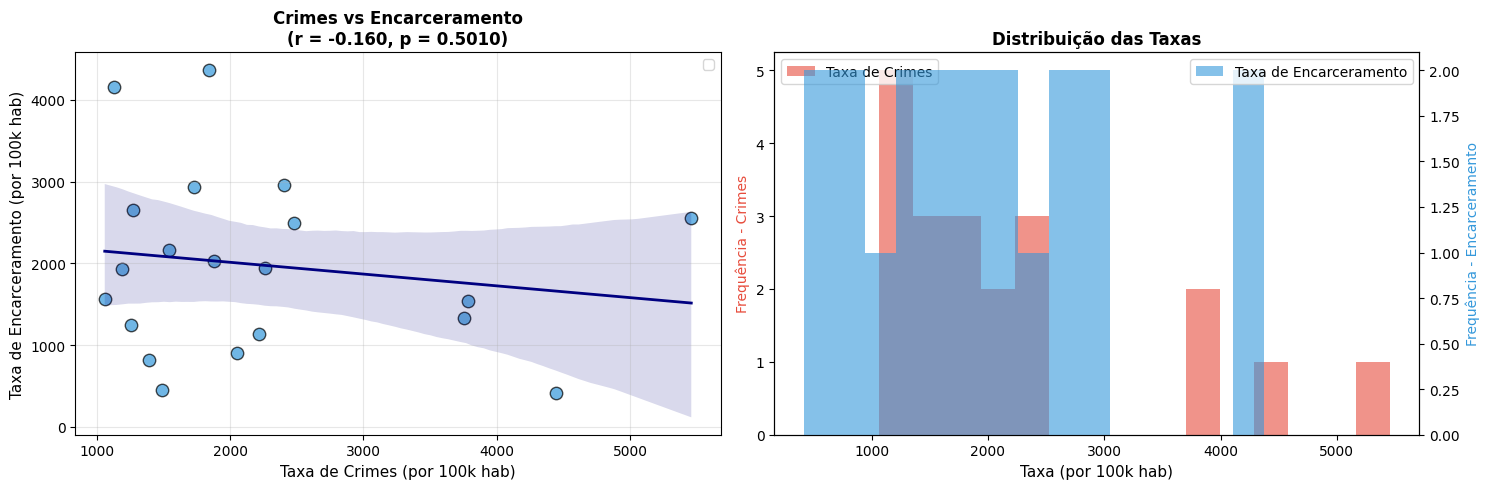


🔝 TOP 5 MUNICÍPIOS COM MAIOR TAXA DE ENCARCERAMENTO:
   1. Governador Valadares: 4371.4 presos/100k (crimes: 1841.2/100k)
   2. Pouso Alegre: 4158.5 presos/100k (crimes: 1127.3/100k)
   3. Paracatu: 2954.6 presos/100k (crimes: 2401.5/100k)
   4. Passos: 2932.8 presos/100k (crimes: 1726.8/100k)
   5. Juiz de Fora: 2651.1 presos/100k (crimes: 1274.3/100k)

📊 GERANDO FIGURAS SEPARADAS...

📊 GERANDO VISUALIZAÇÕES - CORRELAÇÕES...
✅ Salvo: 'figura_01_correlacoes_pib.png'


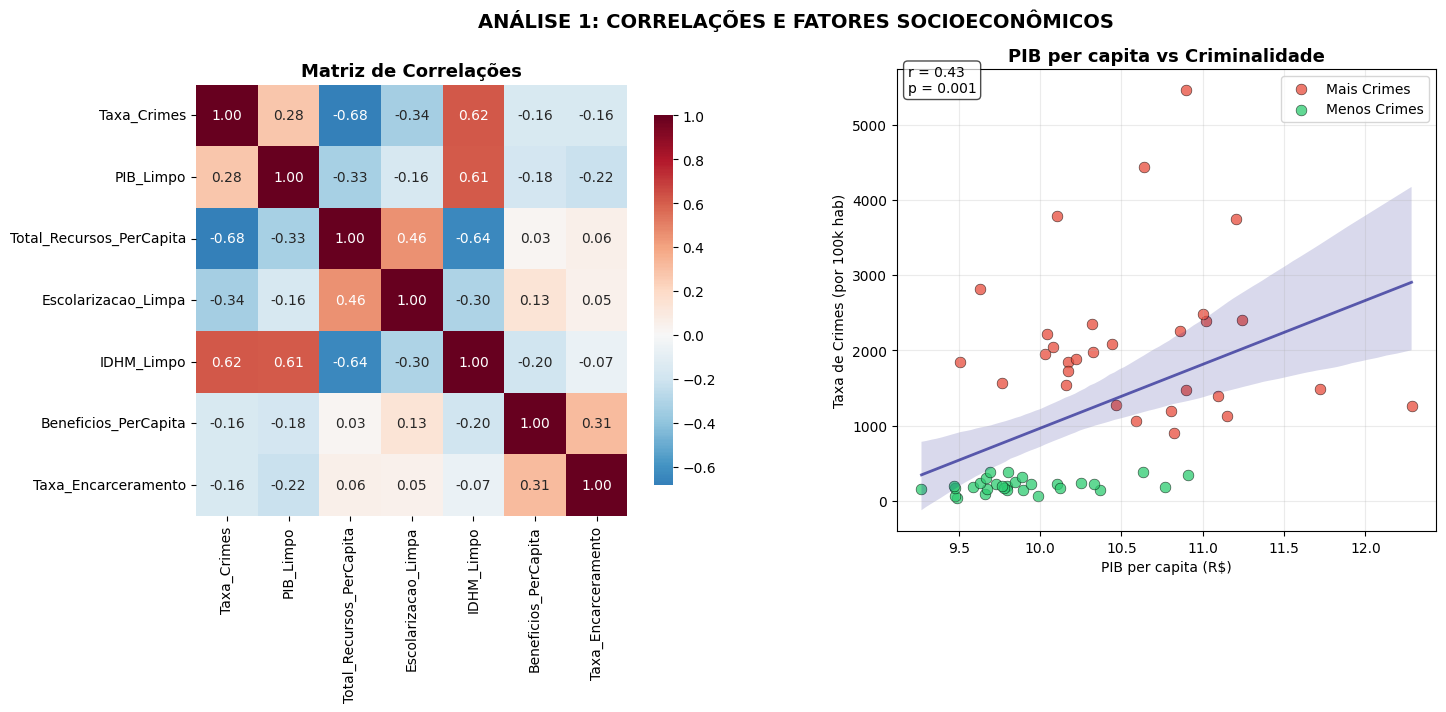


📊 GERANDO VISUALIZAÇÕES - DISTRIBUIÇÕES...
✅ Salvo: 'figura_02_distribuicoes_recursos.png'


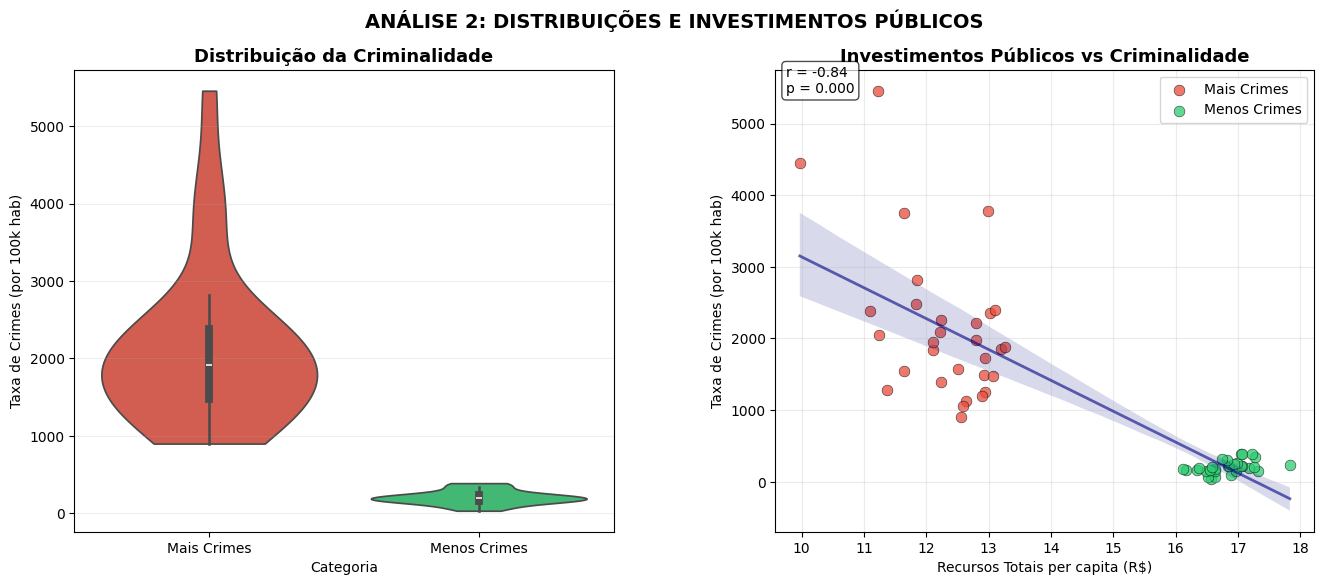


📊 GERANDO VISUALIZAÇÕES - RANKINGS...
✅ Salvo: 'figura_03_rankings_seguranca.png'


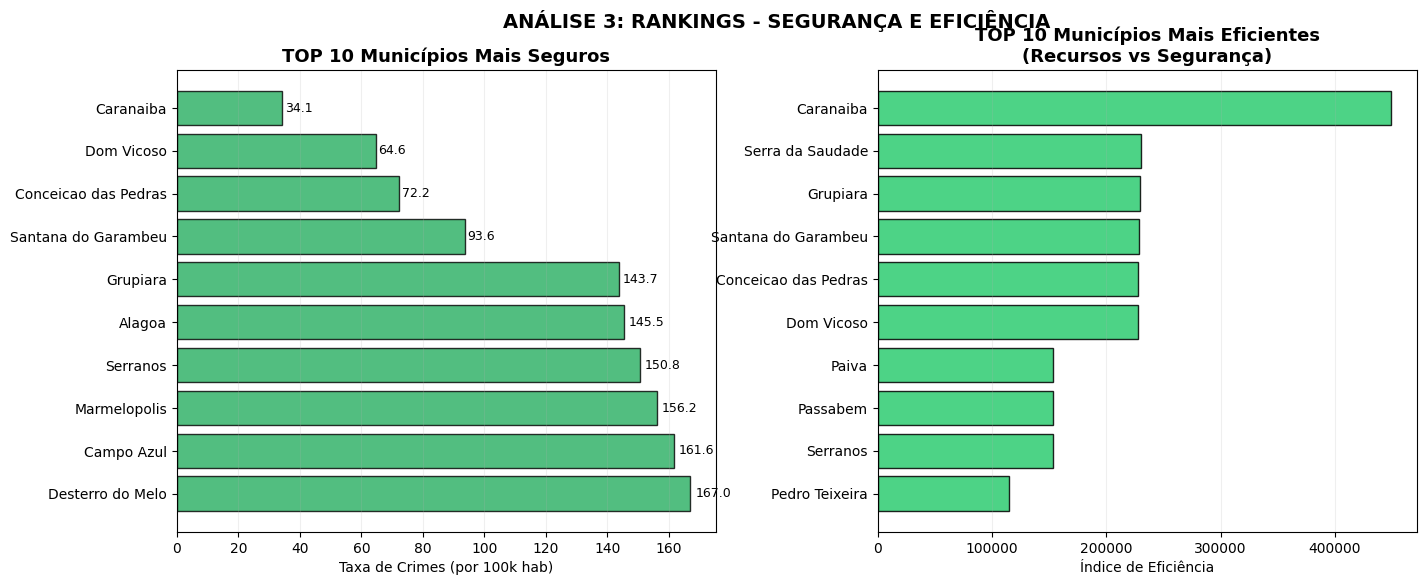


📋 RELATÓRIO EXECUTIVO - CRIMINALIDADE EM MINAS GERAIS

🔗 MATRIZ DE CORRELAÇÕES (Pearson):
                          Taxa_Crimes  PIB_Limpo  Total_Recursos_PerCapita  Escolarizacao_Limpa  IDHM_Limpo  Taxa_Encarceramento
Taxa_Crimes                     1.000      0.282                    -0.683               -0.336       0.623               -0.160
PIB_Limpo                       0.282      1.000                    -0.334               -0.164       0.609               -0.221
Total_Recursos_PerCapita       -0.683     -0.334                     1.000                0.459      -0.642                0.058
Escolarizacao_Limpa            -0.336     -0.164                     0.459                1.000      -0.304                0.050
IDHM_Limpo                      0.623      0.609                    -0.642               -0.304       1.000               -0.065
Taxa_Encarceramento            -0.160     -0.221                     0.058                0.050      -0.065                1.000

➡️ Va

In [32]:
# ============================================================================
# CELL 9 - FUNÇÃO PRINCIPAL (FLUXO COMPLETO)
# ============================================================================
"""
Orquestra toda a análise: carrega dados, faz web scraping, merge,
limpeza, análises e visualizações.
"""

def executar_analise_completa():
    print("🚀 INICIANDO ANÁLISE COMPLETA...")

    # PASSO 1: Carregar dados de crimes
    print("\n📂 CARREGANDO DADOS DE CRIMES...")
    try:
        df_crimes = pd.read_csv('Banco_Crimes_Violentos_2025.csv', encoding='utf-8')
        print(f"✅ Dados de crimes: {len(df_crimes)} registros")
    except FileNotFoundError:
        print("❌ Arquivo de crimes não encontrado!")
        return

    # PASSO 2: Processar crimes
    print("\n📊 PROCESSANDO DADOS DE CRIMES...")

    df_crimes_clean = df_crimes.dropna(subset=['Município', 'Registros'])
    df_crimes_clean['Registros'] = pd.to_numeric(df_crimes_clean['Registros'], errors='coerce')
    df_crimes_clean = df_crimes_clean.dropna(subset=['Registros'])

    crimes_por_municipio = df_crimes_clean.groupby('Município').agg({
        'Registros': 'sum'
    }).reset_index()

    crimes_por_municipio.columns = ['Município', 'Total_Crimes']
    crimes_por_municipio = crimes_por_municipio.sort_values('Total_Crimes', ascending=False)

    n_municipios_mais = 30
    n_municipios_menos = 30

    municipios_mais_crimes = crimes_por_municipio.head(n_municipios_mais)
    municipios_menos_crimes = crimes_por_municipio.nsmallest(n_municipios_menos, 'Total_Crimes')

    if len(municipios_menos_crimes) < n_municipios_menos:
        municipios_filtrados = crimes_por_municipio[
            (crimes_por_municipio['Total_Crimes'] >= 100) &
            (crimes_por_municipio['Total_Crimes'] <= 200)
        ]
        if len(municipios_filtrados) >= n_municipios_menos:
            municipios_menos_crimes = municipios_filtrados.tail(n_municipios_menos)
        else:
            municipios_menos_crimes = municipios_filtrados

    resultado_final = pd.concat([
        municipios_mais_crimes.assign(Categoria='Mais_Crimes'),
        municipios_menos_crimes.assign(Categoria='Menos_Crimes')
    ], ignore_index=True)

    resultado_final.to_csv('municipios_selecionados_crimes.csv', index=False, encoding='utf-8')

    print(f"✅ Selecionados: {len(municipios_mais_crimes)} (mais) + {len(municipios_menos_crimes)} (menos)")

    todos_municipios = [limpar_nome_municipio(m) for m in resultado_final['Município'].tolist()]

    # PASSO 3: Web scraping IBGE
    try:
        df_ibge = pd.read_csv('dados_municipios_ibge.csv', encoding='utf-8')
        print("✅ Dados IBGE já existem")
    except FileNotFoundError:
        print("📡 Buscando IBGE...")
        df_ibge = web_scraping_ibge(todos_municipios)
        if df_ibge.empty:
            print("❌ Falha IBGE")
            return

    # PASSO 4: Códigos IBGE
    try:
        df_com_codigos = pd.read_csv('dados_populacao_com_codigos.csv', encoding='utf-8')
        print("✅ Códigos IBGE já existem")
    except FileNotFoundError:
        print("📡 Buscando códigos...")
        codigos_ibge = web_scraping_codigos_ibge()

        df_ibge['Codigo_IBGE'] = 'Não encontrado'
        encontrados = 0

        for index, row in df_ibge.iterrows():
            municipio = row['Municipio']
            municipio_sem_acento = remover_acentos(municipio.lower())

            if municipio_sem_acento in codigos_ibge:
                codigo = codigos_ibge[municipio_sem_acento]['codigo']
                df_ibge.at[index, 'Codigo_IBGE'] = codigo
                encontrados += 1

        df_com_codigos = df_ibge.copy()
        df_com_codigos.to_csv('dados_populacao_com_codigos.csv', index=False, encoding='utf-8')
        print(f"✅ Códigos: {encontrados}/{len(df_ibge)}")

    # PASSO 5: Orçamentos
    try:
        df_orcamentos = pd.read_csv('orcamentos_municipios.csv', encoding='utf-8')
        print("✅ Dados orçamentários já existem")
    except FileNotFoundError:
        print("📡 Buscando orçamentos...")
        df_validos = df_com_codigos[
            (df_com_codigos["Codigo_IBGE"] != "Não encontrado") &
            (df_com_codigos["Codigo_IBGE"].notna())
        ]

        df_orcamentos = web_scraping_orcamentos(df_validos)
        if df_orcamentos.empty:
            print("⚠️ Nenhum orçamento encontrado")
            df_orcamentos = pd.DataFrame()

    # PASSO 6: Merge
    print("\n🔗 FAZENDO MERGE...")

    df_crimes_agrupado = df_crimes_clean.groupby('Cod IBGE').agg({
        'Registros': 'sum',
        'Município': 'first'
    }).reset_index()

    df_crimes_agrupado.rename(columns={
        'Registros': 'Total_Crimes',
        'Município': 'Municipio_Crimes'
    }, inplace=True)

    df_ibge_filtrado = df_ibge[df_ibge['Municipio'].str.strip().str.upper().isin(
        resultado_final['Município'].str.strip().str.upper().tolist()
    )].copy()

    df_ibge_filtrado['Municipio_Clean'] = df_ibge_filtrado['Municipio'].str.strip().str.upper()
    df_crimes_agrupado['Municipio_Clean'] = df_crimes_agrupado['Municipio_Crimes'].str.strip().str.upper()

    df_completo = pd.merge(
        df_ibge_filtrado,
        df_crimes_agrupado,
        left_on='Municipio_Clean',
        right_on='Municipio_Clean',
        how='inner'
    )

    resultado_final['Municipio_Clean'] = resultado_final['Município'].str.strip().str.upper()
    df_completo = pd.merge(
        df_completo,
        resultado_final[['Municipio_Clean', 'Categoria']],
        on='Municipio_Clean',
        how='left'
    )

    if not df_orcamentos.empty:
        df_orcamentos['Recursos_Estado_Limpo'] = df_orcamentos['recursos_estado'].apply(limpar_valor_orcamento)
        df_orcamentos['Recursos_Municipio_Limpo'] = df_orcamentos['recursos_municipio'].apply(limpar_valor_orcamento)
        df_orcamentos['Gastos_Diretos_Limpo'] = df_orcamentos['gastos_diretos'].apply(limpar_valor_orcamento)
        df_orcamentos['Beneficios_Limpo'] = df_orcamentos['beneficios'].apply(limpar_valor_orcamento)

        df_orcamentos['Total_Recursos_Limpo'] = (
            df_orcamentos['Recursos_Estado_Limpo'].fillna(0) +
            df_orcamentos['Recursos_Municipio_Limpo'].fillna(0) +
            df_orcamentos['Gastos_Diretos_Limpo'].fillna(0)
        )

        df_orcamentos['Municipio_Clean'] = df_orcamentos['municipio'].str.strip().str.upper()

        df_completo = pd.merge(
            df_completo,
            df_orcamentos[['Municipio_Clean', 'Recursos_Estado_Limpo', 'Recursos_Municipio_Limpo',
                           'Gastos_Diretos_Limpo', 'Beneficios_Limpo', 'Total_Recursos_Limpo']],
            on='Municipio_Clean',
            how='left'
        )

    print(f"✅ Merge: {len(df_completo)} municípios")

    # PASSO 7: Limpeza
    print("\n🧹 LIMPANDO DADOS...")

    df_completo['Populacao_Limpa'] = df_completo['População no último censo'].apply(limpar_numero_melhorado)
    df_completo['Taxa_Crimes'] = (df_completo['Total_Crimes'] / df_completo['Populacao_Limpa']) * 100000

    df_completo['Escolarizacao_Limpa'] = df_completo['Escolarização6 a 14 anos'].apply(limpar_valor_melhorado)
    df_completo['PIB_Limpo'] = df_completo['PIB per capita'].apply(limpar_valor_melhorado)
    df_completo['IDHM_Limpo'] = df_completo['IDHMÍndice de desenvolvimento humano municipal'].apply(limpar_valor_melhorado)
    df_completo['Densidade_Limpa'] = df_completo['Densidade demográfica'].apply(limpar_valor_melhorado)

    if not df_orcamentos.empty:
        df_completo['Total_Recursos_PerCapita'] = df_completo['Total_Recursos_Limpo'] / df_completo['Populacao_Limpa']
        df_completo['Beneficios_PerCapita'] = df_completo['Beneficios_Limpo'] / df_completo['Populacao_Limpa']

    df_final = df_completo[df_completo['Taxa_Crimes'].notna() &
                          np.isfinite(df_completo['Taxa_Crimes'])].copy()

    print(f"✅ {len(df_final)} municípios processados")

    # ========================================================
    # PASSO 7.5: INTEGRAR DADOS CARCERÁRIOS (NOVO!)
    # ========================================================
    print("\n🏛️ INTEGRANDO DADOS CARCERÁRIOS...")
    
    try:
        df_carcerario = carregar_e_processar_dados_carcerarios()
        
        if not df_carcerario.empty:
            df_final = calcular_taxa_encarceramento(df_final, df_carcerario)
            print("✅ Dados carcerários integrados!")
        else:
            print("⚠️ Sem dados carcerários, continuando...")
    
    except Exception as e:
        print(f"⚠️ Erro encarceramento: {e}")

    # PASSO 8: Análises
    print("\n🔬 EXECUTANDO ANÁLISES...")

    df_final = analises_estatisticas_avancadas(df_final)
    modelo, r2 = criar_modelo_preditivo(df_final)

    # NOVO: Análise de correlação crimes vs encarceramento
    if 'Taxa_Encarceramento' in df_final.columns:
        correlacao_crimes_encarceramento(df_final)

    # ✨ SEPARAR EM 3 FIGURAS
    print("\n📊 GERANDO FIGURAS SEPARADAS...")
    criar_visualizacoes_correlacoes(df_final)
    criar_visualizacoes_distribuicoes(df_final)
    criar_visualizacoes_rankings(df_final)

    gerar_relatorio_executivo(df_final)

    # PASSO 9: Salvar
    df_final.to_csv('analise_completa_final_melhorada.csv', index=False, encoding='utf-8')
    print(f"\n💾 Dados salvos em 'analise_completa_final_melhorada.csv'")

    print("\n🎉 ANÁLISE FINALIZADA COM SUCESSO!")
    print("="*80)

# ============================================================================
# EXECUTAR
# ============================================================================

if __name__ == "__main__":
    executar_analise_completa()

In [30]:
import folium
from folium import plugins
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time
import os

def converter_html_para_png(arquivo_html, arquivo_png, resolucao=(1400, 900)):
    """
    Converte arquivo HTML (mapa Folium) para PNG usando Selenium.
    
    Parâmetros:
    - arquivo_html: caminho do arquivo .html (ex: 'mapa_municipios_crimes.html')
    - arquivo_png: caminho de saída .png (ex: 'mapa_municipios_crimes.png')
    - resolucao: tupla (largura, altura) da imagem em pixels
    """
    print(f"\n📸 Convertendo {arquivo_html} para PNG...")
    
    try:
        # Verificar se arquivo HTML existe
        if not os.path.exists(arquivo_html):
            print(f"   ❌ Arquivo não encontrado: {arquivo_html}")
            return False
        
        # Configurar Chrome para headless (sem interface gráfica)
        chrome_options = Options()
        chrome_options.add_argument("--headless")           # Rodar sem interface gráfica
        chrome_options.add_argument("--no-sandbox")         # Desabilitar sandbox
        chrome_options.add_argument("--disable-dev-shm-usage")  # Usar disco em vez de /dev/shm
        chrome_options.add_argument(f"--window-size={resolucao[0]},{resolucao[1]}")  # Tamanho da janela
        chrome_options.add_argument("--disable-blink-features=AutomationControlled")
        chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
        chrome_options.add_experimental_option('useAutomationExtension', False)
        
        # Usar webdriver-manager para encontrar ChromeDriver automaticamente
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        
        # Abrir arquivo HTML local
        caminho_absoluto = os.path.abspath(arquivo_html)
        driver.get(f"file:///{caminho_absoluto}")
        
        # Aguardar carregamento completo do mapa
        time.sleep(4)
        
        # Capturar screenshot
        driver.save_screenshot(arquivo_png)
        driver.quit()
        
        print(f"   ✅ Imagem salva com sucesso: {arquivo_png}")
        return True
        
    except ImportError as e:
        print(f"   ❌ Erro de importação: {e}")
        print(f"   💡 Instale as dependências:")
        print(f"      pip install selenium webdriver-manager")
        return False
        
    except Exception as e:
        print(f"   ❌ Erro durante conversão: {e}")
        print(f"   💡 Dicas:")
        print(f"      - Verifique se Chrome/Chromium está instalado")
        print(f"      - Tente atualizar: pip install --upgrade selenium webdriver-manager")
        return False


# ============================================================================
# CELL 10 - MAPAS GEOESPACIAIS (FOLIUM)
# ============================================================================
"""
Cria mapas interativos mostrando distribuição geoespacial dos municípios.
Deve ser executada APÓS a CELL 9 (executar_analise_completa).
"""

import folium
from folium import plugins

df_final = pd.read_csv('analise_completa_final_melhorada.csv')

def gerar_todos_os_mapas(df_final):
    """
    Função wrapper que gera todos os 3 mapas de uma vez.
    
    Parâmetros:
    - df_final: DataFrame com os dados finais (output da CELL 9)
    """
    print("\n" + "="*70)
    print("🗺️  GERANDO MAPAS GEOESPACIAIS")
    print("="*70)
    
    # Dicionário com coordenadas dos municípios de MG
    coordenadas_mg = {
        'Belo Horizonte': [-19.9191, -43.9386],
        'Contagem': [-19.9301, -44.0582],
        'Betim': [-19.9653, -44.2833],
        'Nova Serrana': [-20.4242, -45.7769],
        'Serra da Saudade': [-18.5833, -45.1833],
        'Governador Valadares': [-18.8606, -41.9453],
        'Pouso Alegre': [-22.2265, -45.9361],
        'Paracatu': [-18.2069, -46.8652],
        'Passos': [-20.6167, -46.6167],
        'Juiz de Fora': [-21.7626, -43.3581],
        'Caranã': [-17.9, -41.8],
        'Dom Viçoso': [-21.0231, -42.8641],
        'Conceição das Pedras': [-21.4, -43.2],
        'Santana do Garambéu': [-20.5, -44.9],
        'Grupiara': [-20.1, -46.4],
        'Alagoa': [-21.0, -45.5],
        'Serrano': [-20.3, -43.8],
        'Marmelópolis': [-22.4, -45.8],
        'Campo Azul': [-21.2, -44.5],
        'Desterro do Melo': [-20.1, -44.8],
    }
    
    # Preparar DataFrame
    df = df_final.copy()
    
    # Adicionar coordenadas (usa BH como padrão se não encontrar)
    df['latitude'] = df['Municipio'].map(
        lambda x: coordenadas_mg.get(x, [-19.9191, -43.9386])[0]
    )
    df['longitude'] = df['Municipio'].map(
        lambda x: coordenadas_mg.get(x, [-19.9191, -43.9386])[1]
    )
    
    # ========================================
    # MAPA 1: Marcadores coloridos por crime
    # ========================================
    criar_mapa_municipios(df, coordenadas_mg)
    
    # ========================================
    # MAPA 2: Mapa de calor
    # ========================================
    criar_mapa_heatmap(df, coordenadas_mg)
    
    # ========================================
    # MAPA 3: Clusters
    # ========================================
    if 'Cluster' in df.columns:
        criar_mapa_clusters(df, coordenadas_mg)
    else:
        print("\n⚠️  Coluna 'Cluster' não encontrada - pulando mapa de clusters")
    
     # ✨ NOVO: Converter mapas para PNG
    print("\n" + "="*70)
    print("📸 CONVERTENDO MAPAS PARA IMAGENS...")
    print("="*70)
    
    mapas_para_converter = [
        ('mapa_municipios_crimes.html', 'mapa_municipios_crimes.png'),
        ('mapa_calor_crimes.html', 'mapa_calor_crimes.png'),
        ('mapa_clusters_municipios.html', 'mapa_clusters_municipios.png')
    ]
    
    for html_file, png_file in mapas_para_converter:
        try:
            # Converter apenas se o arquivo HTML existir
            import os
            if os.path.exists(html_file):
                converter_html_para_png(html_file, png_file, resolucao=(1400, 900))
            else:
                print(f"⚠️  {html_file} não encontrado")
        except Exception as e:
            print(f"⚠️  Erro ao converter {html_file}: {e}")
    
    print("\n" + "="*70)
    print("✅ TODOS OS MAPAS GERADOS COM SUCESSO!")
    print("="*70)


def criar_mapa_municipios(df, coordenadas_mg):
    """
    MAPA 1: Marcadores coloridos mostrando Taxa de Crimes por município.
    🔴 Vermelho = Alta criminalidade
    🟠 Laranja = Média criminalidade  
    🟢 Verde = Baixa criminalidade
    """
    print("\n🗺️  1. Criando mapa de marcadores...")
    
    # Mapa centrado em Minas Gerais
    mapa = folium.Map(
        location=[-19.5, -44.0],
        zoom_start=7,
        tiles='OpenStreetMap'
    )
    
    # Normalizar cores pela Taxa de Crimes
    taxa_min = df['Taxa_Crimes'].min()
    taxa_max = df['Taxa_Crimes'].max()
    
    # Adicionar marcadores para cada município
    for idx, row in df.dropna(subset=['latitude', 'longitude']).iterrows():
        municipio = row['Municipio']
        taxa = row['Taxa_Crimes']
        categoria = row.get('Categoria', 'Neutro')
        
        # Determinar cor baseada em Taxa de Crimes
        if taxa > taxa_max * 0.66:
            cor = 'red'        # Alto crime
            icone = 'exclamation-triangle'
        elif taxa > taxa_max * 0.33:
            cor = 'orange'     # Médio crime
            icone = 'exclamation-circle'
        else:
            cor = 'green'      # Baixo crime
            icone = 'check-circle'
        
        # Montar texto do popup
        popup_text = f"""
        <b style="font-size: 14px;">{municipio}</b><br>
        <hr style="margin: 5px 0;">
        <b>Taxa de Crimes:</b> {taxa:.1f} por 100k hab<br>
        <b>Categoria:</b> {categoria.replace('_', ' ')}<br>
        """
        
        # Adicionar dados adicionais se disponíveis
        if 'Taxa_Encarceramento' in row and pd.notna(row['Taxa_Encarceramento']):
            popup_text += f"<b>Encarceramento:</b> {row['Taxa_Encarceramento']:.1f} por 100k<br>"
        
        if 'PIB_Limpo' in row and pd.notna(row['PIB_Limpo']):
            popup_text += f"<b>PIB per capita:</b> R$ {row['PIB_Limpo']:,.0f}<br>"
        
        if 'Populacao_Limpa' in row and pd.notna(row['Populacao_Limpa']):
            popup_text += f"<b>População:</b> {row['Populacao_Limpa']:,.0f}"
        
        # Adicionar marcador ao mapa
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=350),
            tooltip=f"{municipio} - {taxa:.1f} crimes/100k",
            icon=folium.Icon(color=cor, icon=icone, prefix='fa')
        ).add_to(mapa)
    
    # Adicionar legenda
    legenda_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 220px; height: 180px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px; border-radius: 5px;">
        <p style="margin: 0 0 10px 0; font-weight: bold;">🗺️ Legenda - Taxa de Crimes</p>
        <p style="margin: 5px 0;"><i class="fa fa-map-marker" style="color:red"></i> 
           <b>Alto:</b> > 66% do máximo</p>
        <p style="margin: 5px 0;"><i class="fa fa-map-marker" style="color:orange"></i> 
           <b>Médio:</b> 33-66% do máximo</p>
        <p style="margin: 5px 0;"><i class="fa fa-map-marker" style="color:green"></i> 
           <b>Baixo:</b> < 33% do máximo</p>
        <p style="margin: 10px 0 0 0; font-size: 12px; color: gray;">
           Clique nos marcadores para mais informações
        </p>
    </div>
    '''
    mapa.get_root().html.add_child(folium.Element(legenda_html))
    
    # Salvar mapa
    mapa.save('mapa_municipios_crimes.html')
    print("   ✅ Salvo: 'mapa_municipios_crimes.html'")


def criar_mapa_heatmap(df, coordenadas_mg):
    """
    MAPA 2: Mapa de calor (heatmap) mostrando intensidade de crimes.
    Quanto mais QUENTE (vermelho), mais crimes naquela região.
    """
    print("\n🔥 2. Criando mapa de calor...")
    
    # Mapa base
    mapa_calor = folium.Map(
        location=[-19.5, -44.0],
        zoom_start=7,
        tiles='OpenStreetMap'
    )
    
    # Preparar dados para heatmap (lista de [lat, lon, intensidade])
    dados_calor = []
    for idx, row in df.dropna(subset=['latitude', 'longitude', 'Taxa_Crimes']).iterrows():
        # Normalizar taxa para 0-1
        taxa_normalizada = (row['Taxa_Crimes'] - df['Taxa_Crimes'].min()) / (
            df['Taxa_Crimes'].max() - df['Taxa_Crimes'].min()
        )
        dados_calor.append([row['latitude'], row['longitude'], taxa_normalizada])
    
    # Adicionar camada de calor
    plugins.HeatMap(
        dados_calor, 
        radius=35,           # Raio de influência
        blur=25,             # Suavização
        max_zoom=1,
        min_opacity=0.3,
        gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'}
    ).add_to(mapa_calor)
    
    # Adicionar legenda
    legenda_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 200px; height: 150px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:13px; padding: 10px; border-radius: 5px;">
        <p style="margin: 0 0 10px 0; font-weight: bold;">🔥 Legenda - Intensidade</p>
        <p style="margin: 5px 0;"><span style="background:blue; width: 20px; height: 10px; display: inline-block;"></span> Baixo</p>
        <p style="margin: 5px 0;"><span style="background:cyan; width: 20px; height: 10px; display: inline-block;"></span> Médio-Baixo</p>
        <p style="margin: 5px 0;"><span style="background:yellow; width: 20px; height: 10px; display: inline-block;"></span> Médio</p>
        <p style="margin: 5px 0;"><span style="background:orange; width: 20px; height: 10px; display: inline-block;"></span> Alto</p>
        <p style="margin: 5px 0;"><span style="background:red; width: 20px; height: 10px; display: inline-block;"></span> Muito Alto</p>
    </div>
    '''
    mapa_calor.get_root().html.add_child(folium.Element(legenda_html))
    
    # Salvar mapa
    mapa_calor.save('mapa_calor_crimes.html')
    print("   ✅ Salvo: 'mapa_calor_crimes.html'")


def criar_mapa_clusters(df, coordenadas_mg):
    """
    MAPA 3: Mapa mostrando os clusters (agrupamentos) de municípios.
    Cada cor representa um cluster diferente.
    """
    print("\n📍 3. Criando mapa de clusters...")
    
    # Mapa base
    mapa_clusters = folium.Map(
        location=[-19.5, -44.0],
        zoom_start=7,
        tiles='OpenStreetMap'
    )
    
    # Cores para clusters
    cores_clusters = {
        0: 'purple',
        1: 'blue',
        2: 'green',
        3: 'orange',
        4: 'red'
    }
    
    # Adicionar marcadores por cluster
    for idx, row in df.dropna(subset=['latitude', 'longitude', 'Cluster']).iterrows():
        cluster = int(row['Cluster'])
        cor = cores_clusters.get(cluster, 'gray')
        
        popup_text = f"""
        <b style="font-size: 14px;">{row['Municipio']}</b><br>
        <hr style="margin: 5px 0;">
        <b>Cluster:</b> {cluster}<br>
        <b>Taxa de Crimes:</b> {row['Taxa_Crimes']:.1f} por 100k<br>
        """
        
        if 'PIB_Limpo' in row and pd.notna(row['PIB_Limpo']):
            popup_text += f"<b>PIB per capita:</b> R$ {row['PIB_Limpo']:,.0f}<br>"
        
        if 'Escolarizacao_Limpa' in row and pd.notna(row['Escolarizacao_Limpa']):
            popup_text += f"<b>Escolarização:</b> {row['Escolarizacao_Limpa']:.1f}%"
        
        # Adicionar marcador circular
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=350),
            tooltip=f"{row['Municipio']} - Cluster {cluster}",
            radius=12,
            color=cor,
            fill=True,
            fillColor=cor,
            fillOpacity=0.7,
            weight=3
        ).add_to(mapa_clusters)
    
    # Adicionar legenda
    cluster_names = {
        0: "Cluster 0 (Padrão)",
        1: "Cluster 1 (Padrão)",
        2: "Cluster 2 (Padrão)",
        3: "Cluster 3 (Padrão)",
        4: "Cluster 4 (Padrão)"
    }
    
    legenda_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 200px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:13px; padding: 10px; border-radius: 5px;">
        <p style="margin: 0 0 10px 0; font-weight: bold;">📍 Legenda - Clusters</p>
    '''
    
    for cluster, cor in cores_clusters.items():
        legenda_html += f'''
        <p style="margin: 5px 0;">
            <span style="background:{cor}; width: 15px; height: 15px; 
                   border-radius: 50%; display: inline-block;"></span> 
            Cluster {cluster}
        </p>
        '''
    
    legenda_html += '</div>'
    
    mapa_clusters.get_root().html.add_child(folium.Element(legenda_html))
    
    # Salvar mapa
    mapa_clusters.save('mapa_clusters_municipios.html')
    print("   ✅ Salvo: 'mapa_clusters_municipios.html'")


# ============================================================================
# EXECUTAR OS MAPAS
# ============================================================================
# Esta célula deve ser executada APÓS a CELL 9
# Descomente a linha abaixo para rodar automaticamente:

gerar_todos_os_mapas(df_final)


🗺️  GERANDO MAPAS GEOESPACIAIS

🗺️  1. Criando mapa de marcadores...
   ✅ Salvo: 'mapa_municipios_crimes.html'

🔥 2. Criando mapa de calor...
   ✅ Salvo: 'mapa_calor_crimes.html'

📍 3. Criando mapa de clusters...
   ✅ Salvo: 'mapa_clusters_municipios.html'

📸 CONVERTENDO MAPAS PARA IMAGENS...

📸 Convertendo mapa_municipios_crimes.html para PNG...
   ✅ Imagem salva com sucesso: mapa_municipios_crimes.png

📸 Convertendo mapa_calor_crimes.html para PNG...
   ✅ Imagem salva com sucesso: mapa_calor_crimes.png

📸 Convertendo mapa_clusters_municipios.html para PNG...
   ✅ Imagem salva com sucesso: mapa_clusters_municipios.png

✅ TODOS OS MAPAS GERADOS COM SUCESSO!
